## Importing Libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

## Image Data Ingestion

In [2]:
# There are two images on which we will work on:
# data_test contains an image with a lot of noise which is best to represent M2GLD Algorithm
data_test=".\\Test Images\\TestImage.jpg"
data_path=".\\Data\\Positive"
img_path_t="00655.jpg"

In [3]:
def resized_frame(image):
    width=256
    height=256
    dimensions=(width,height)
    return cv.resize(image,dimensions,interpolation=cv.INTER_AREA)

In [4]:
img=cv.imread(os.path.join(data_test),cv.IMREAD_COLOR)
img=resized_frame(img)
cv.imshow('Raw Image',img)
cv.waitKey(0)

-1

### Standard Image Pre-processing

In [5]:
gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
cv.imshow('Standard Grayscale Image',gray)
cv.waitKey(0)

-1

In [6]:
blur=cv.GaussianBlur(gray,(5,5),0)
cv.imshow('Standard Blur Gray Image',img)
cv.waitKey(0)

-1

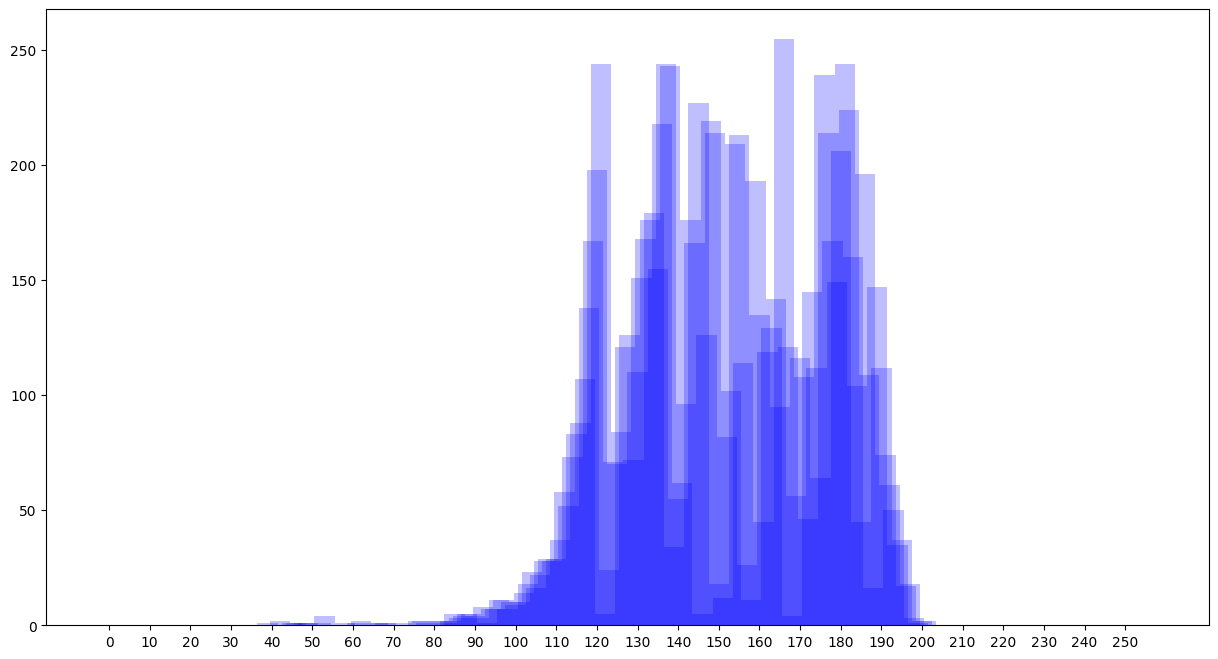

In [7]:
#Histogram Pixel Intensities
def Hist(img):
    row,col= img.shape[:2] 
    y = np.zeros(256,dtype='uint8')
    for i in range(0,row): 
        for j in range(0,col):
            y[img[i,j]] += 1
            
    x = np.arange(0,256)
    plt.figure(figsize=(15,8))
    plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
    plt.xticks(np.arange(0,256,step=10))
    plt.show()
    return y
y=Hist(gray);

In [8]:
img.shape

(256, 256, 3)

In [9]:
#Threshold Selection (Manual Selection)
threshold,thresh=cv.threshold(blur,128,255,cv.THRESH_BINARY)
cv.imshow('Standard Binarized Image',thresh)
cv.waitKey(0)

-1

In [10]:
#Feature Detection and Description using ORB Algorithm
orb = cv.ORB_create(nfeatures=1500)
# Make featured Image
keypoints, descriptors = orb.detectAndCompute(thresh, None)
featuredImg = cv.drawKeypoints(thresh, keypoints, None)
cv.imshow('Featured Detection using ORB',featuredImg)
cv.waitKey(0)

-1

## Otsu Thresholding

In [11]:
gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
cv.imshow('Otsu Grayscale Image',gray)
cv.waitKey(0)

-1

In [12]:
blur=cv.GaussianBlur(gray,(5,5),0)
cv.imshow('Otsu Blurred Image',blur)
cv.waitKey(0)

-1

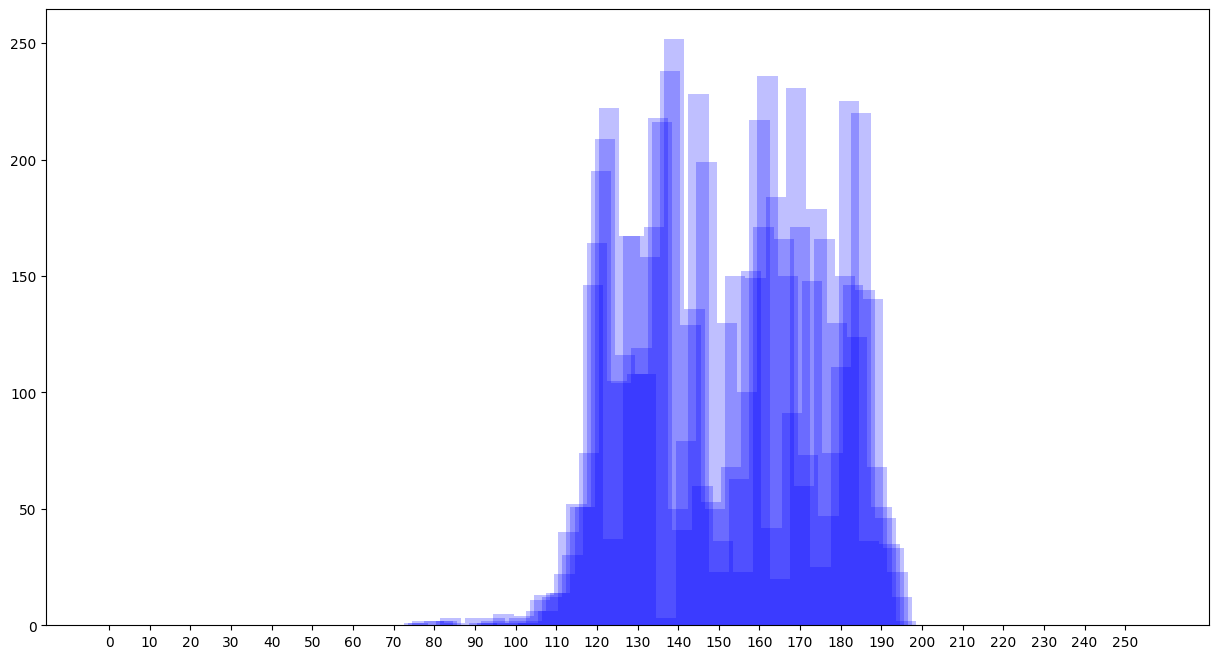

In [13]:
# Plotting Histogram for the grayscale Image
def calc_hist(img_enhanced):
    gray_hist=cv.calcHist([img_enhanced],[0],None,[256],[0,256])
    gray_hist=gray_hist.flatten()
    Hist(img_enhanced)
    return gray_hist
gray_hist=calc_hist(blur);

In [14]:
#Histogram Normalization
def normalize_histogram(histogram):
    total_pixels = np.sum(histogram)  # Calculate the total number of pixels
    normalized_histogram = histogram.astype(float) / total_pixels  # Normalize the histogram
    return normalized_histogram

norm_gray_hist=normalize_histogram(gray_hist)

In [15]:
# Cumulative sum of all bins
def cum_sum_histogram(norm_gray_hist):
    cum_sum=np.cumsum(norm_gray_hist)
    return cum_sum

cum_sum=cum_sum_histogram(norm_gray_hist)
cum_sum[-1]

1.0

In [16]:
#Computing Minimum Threshold value
def compute_minimum_thresh(cum_sum, norm_hist):
    bins = np.arange(256)
    min_fn_values=np.zeros_like(norm_hist)
    
    fn_min=np.inf
    for i in range(len(norm_hist)):
        p1,p2 = np.hsplit(norm_hist,[i]) # probabilities
        q1,q2 = cum_sum[i],cum_sum[255]-cum_sum[i] # cum sum of classes
        
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
            
        b1,b2 = np.hsplit(bins,[i]) # weights
        
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        
        # calculates the minimization function
        min_fn_value = v1*q1 + v2*q2
        min_fn_values[i]=  min_fn_value
        
        
        #finding the minimum value
        if min_fn_value<fn_min:
            fn_min=min_fn_value
            optimal_threshold=i
    
    return optimal_threshold
optimal_thresh=compute_minimum_thresh(cum_sum,norm_gray_hist)
optimal_thresh

153

In [17]:
def otsu_threshold_image(img_enhanced,optimal_threshold):
    threshold,thresh=cv.threshold(img_enhanced,optimal_threshold,255,cv.THRESH_BINARY_INV)
    return thresh
thresh=otsu_threshold_image(blur,optimal_thresh)
cv.imshow('Otsu Thresholded Image',thresh)
cv.waitKey(0)

-1

In [18]:
def otsu_thresholding(gray_img):
    blur_img=cv.GaussianBlur(gray_img,(5,5),0)
    hist_otsu=calc_hist(blur_img)
    norm_hist_otsu=normalize_histogram(hist_otsu)
    cum_sum_otsu=cum_sum_histogram(norm_hist_otsu)
    optimal_thresh_otsu=compute_minimum_thresh(cum_sum_otsu, norm_hist_otsu)
    print('Optimal Threshold',optimal_thresh_otsu)
    thresh_img=otsu_threshold_image(blur_img,optimal_thresh_otsu)
    return thresh_img

In [19]:
orb = cv.ORB_create(nfeatures=1500)

# Make featured Image
keypoints, descriptors = orb.detectAndCompute(thresh, None)
featuredImg = cv.drawKeypoints(thresh, keypoints, None)
cv.imshow('Otsu Feature Detection',featuredImg)
cv.waitKey(0)

-1

## M2GLD Algorithm


In [20]:
img_M2GLD=cv.imread(os.path.join(data_path,img_path_t),cv.IMREAD_COLOR)
img_M2GLD=resized_frame(img_M2GLD)
cv.imshow('Raw Crack Image',img_M2GLD)
cv.waitKey(0)

-1

In [21]:
gray=cv.cvtColor(img_M2GLD,cv.COLOR_BGR2GRAY)
cv.imshow('M2GLD Grayscale Image',gray)
cv.waitKey(0)

-1

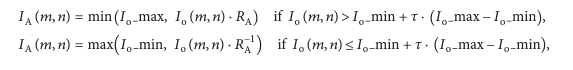

This formula for performing the M2GLD Algorithm was taken from a paper published on **Detection of Surface Crack in Building Structures Using Image Processing Technique with an Improved Otsu Method for Image Thresholding** 

**Nhat-Duc Hoang**

Institute of Research and Development, Faculty of Civil Engineering, Duy Tan University, 03 Quang Trung,
Da Nang 550000, Vietnam


* The tau parameter and R (adjusting ratio) has been set to 0.5 and 1.1


In [22]:
#This is a grayscale enhancement method which enhances a grayscale image and divid it into two groups of pixel intensities
def M2GLD_Apply(img_M2GLD):    
    gray=cv.cvtColor(img_M2GLD,cv.COLOR_BGR2GRAY)
    row,col=img.shape[:2]
    M2GLD_img=np.zeros((row,col),dtype='uint8')
    min_I=300
    max_I=-1
    tau=0.45
    R=1.1

    for i in range(0,row):        
        for j in range(0,col):
            if gray[i,j]<min_I:
                min_I=gray[i,j]
            if gray[i,j]>max_I:
                max_I=gray[i,j]
    range_I=max_I-min_I
    print("Minimum Intensity:{} Maximum Intensity:{} tau:{} R factor:{}".format(min_I,max_I,tau,R))
    fn=(min_I+(tau*(range_I)))
    for i in range(0,row):        
        for j in range(0,col):            
                if gray[i,j]>fn:
                    M2GLD_img[i,j]=np.minimum(min_I,gray[i,j]*R)
                else:
                    M2GLD_img[i,j]=np.maximum(min_I,gray[i,j]*(1/R))
    return M2GLD_img
M2GLD_img_1=M2GLD_Apply(img_M2GLD);

Minimum Intensity:25 Maximum Intensity:239 tau:0.45 R factor:1.1


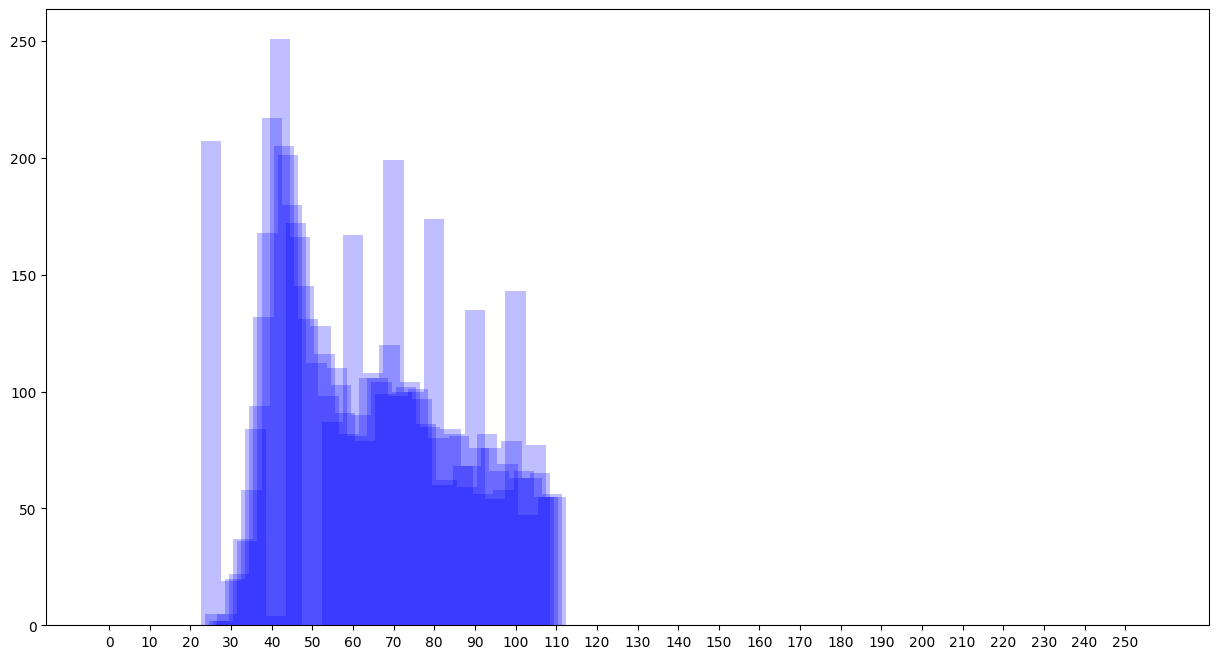

In [23]:
Hist(M2GLD_img_1);

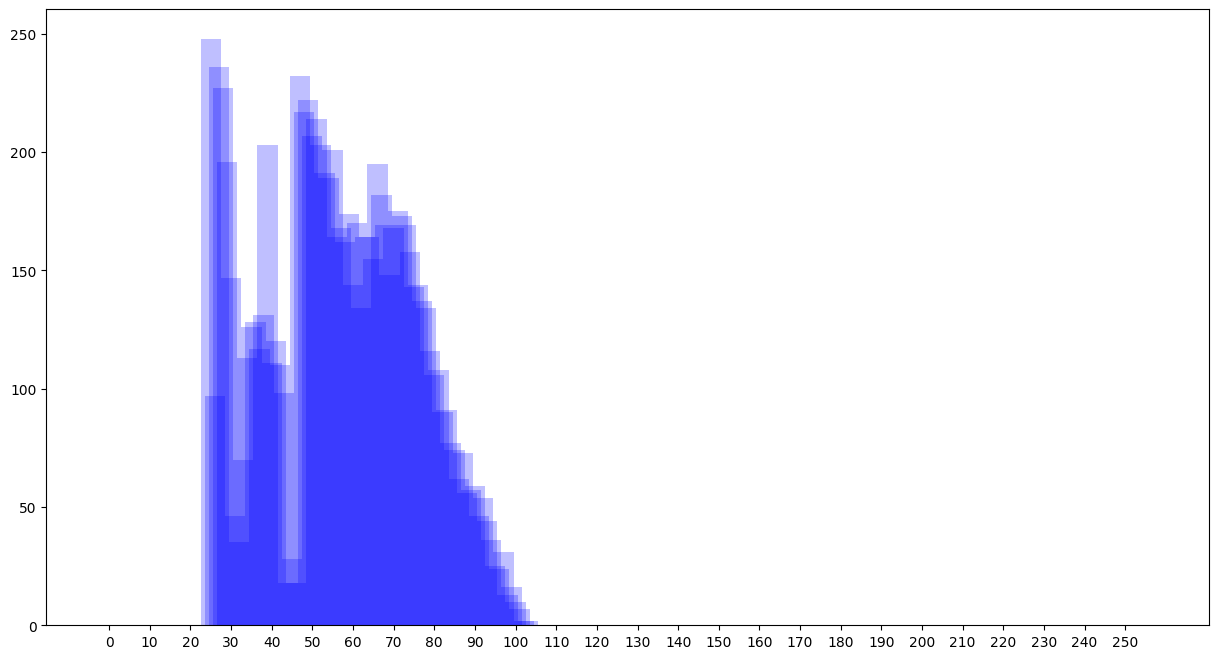

In [24]:
blur_MGLD=cv.GaussianBlur(M2GLD_img_1,(5,5),0)
Hist(blur_MGLD);

In [25]:
threshold,thresh=cv.threshold(M2GLD_img_1,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
print(threshold)
cv.imshow('M2GLD Automatic Otsu',thresh)
cv.waitKey(0)

52.0


-1

### M2GLD & Otsu Thresholding Combined

Minimum Intensity:25 Maximum Intensity:239 tau:0.45 R factor:1.1


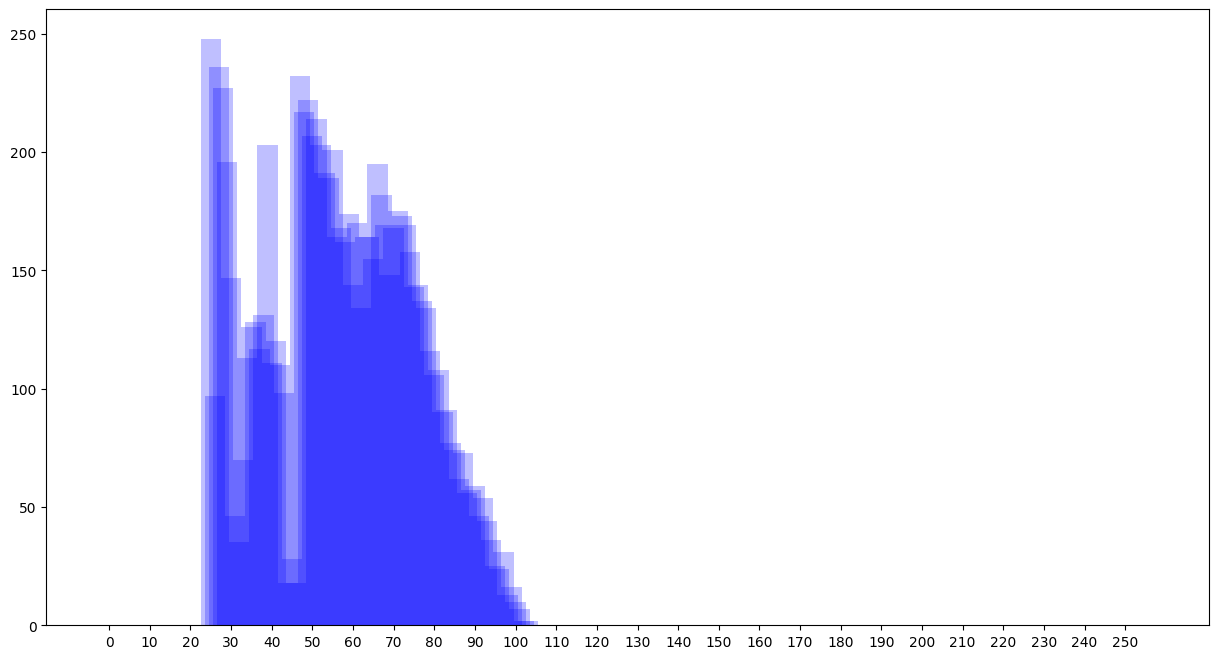

Optimal Threshold 47


-1

In [28]:
def M2GLD_Otsu(user_input_image):
    M2GLD_img=M2GLD_Apply(user_input_image)
    otsu_img=otsu_thresholding(M2GLD_img)
    return otsu_img

Enhanced_img=M2GLD_Otsu(img_M2GLD)
cv.imshow('Enhanced Surface Crack Image',Enhanced_img)
cv.imshow('Raw Image',img_M2GLD)
cv.waitKey(0)

After performing many experimentations with the value of R (Adjusting Ratio) and tau, This was found that there values
depend on the set of images. For example, The building crack images have a effective parameter values of 1.1 and 0.5 for R 
tau respectively and likewise for the crack image set provided with this project, the initial parameter values that were
proposed in the paper, are the most effective in defining a crack.